In [1]:
#time to set conditions with packages

# import packages for analysis and modeling
import pandas as pd  # data frame operations

import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
from urllib.request import urlopen

pd.set_option('display.max_rows', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#time to get/import the data - the coaches data in particular right now
import os
os.getcwd()
from google.colab import files
uploaded = files.upload()


Saving Coaches9.csv to Coaches9.csv


In [3]:
#now time to round out the data - let's start first with some win percentage and overall rankings
ncaapage1 = pd.read_html('https://www.ncaa.com/stats/football/fbs/current/team/742', skiprows=0, header=0)[0]
#print(ncaapage1)
#aha!!! Eureka  Rinse and repeat for the other pages in the list
ncaapage2 = pd.read_html('https://www.ncaa.com/stats/football/fbs/current/team/742/p2', skiprows=0, header=0)[0]
#print(ncaapage2)
ncaapage3 = pd.read_html('https://www.ncaa.com/stats/football/fbs/current/team/742/p3', skiprows=0, header=0)[0]
#print(ncaapage3)

ncaapage1.head()


,Rank,Team,W,L,T,Pct
0,1,Georgia,14,1,0,0.933
1,2,Cincinnati,13,1,0,0.929
2,-,Louisiana,13,1,0,0.929
3,4,Alabama,13,2,0,0.867
4,5,Baylor,12,2,0,0.857


In [ ]:
#now append that webpage with the three pages into a single dataframe
ncaarankings=ncaapage1.append(ncaapage3)
ncaarankings=ncaarankings.append(ncaapage2)
ncaarankings.head()
#ncaarankings.info()

ncaarankings.drop_duplicates()


# rank does not appear to be properly annotating
# So to try to get the data to read in properly and interact with the other data it will be merged with, I am modifying the data types for specific columns and removing the NaNs
ncaarankings['Rank'] = ncaarankings['Rank'].str.replace('-','NaN', case=False)
ncaarankings['Rank']=ncaarankings['Rank'].astype(float, errors='ignore')

ncaarankings['Team']=ncaarankings['Team'].astype(pd.StringDtype())
ncaarankings.info()

pd.set_option('display.max_rows', None)
print(ncaarankings)

In [ ]:
# A large part of the data munging for me was the conundrum of different naming conventions for the disparate data sources
# I used the coaches9 data as the standard for the naming convention and used a largely brute force technique to get the other naming conventions to fall in in
# Addmittedly, this approach was neither elegent nor efficient and for some reason, Miami of Ohio and Miami of Florida refused any attempt at modifications
ncaarankings['Team'] = ncaarankings['Team'].str.replace('NC State','North Carolina St.', case=False)
ncaarankings['Team'] = ncaarankings['Team'].str.replace('Northern Ill.','Northern Illinois', case=False)
ncaarankings['Team'] = ncaarankings['Team'].str.replace('UCF','Central Florida', case=False)
ncaarankings['Team'] = ncaarankings['Team'].str.replace('UConn','Connecticut', case=False)
ncaarankings['Team'] = ncaarankings['Team'].str.replace('Fla. Atlantic','Fla Atlantic', case=False)
ncaarankings['Team'] = ncaarankings['Team'].str.replace("Miami (OH)","Miami (Ohio)", case=False)
ncaarankings['Team'] = ncaarankings['Team'].str.replace('Miami (FL)','Miami (Fla.)', case=False)
ncaarankings['Team'] = ncaarankings['Team'].str.replace('Middle Tenn.','Middle Tennessee', case=False)
ncaarankings['Team'] = ncaarankings['Team'].str.replace('Mississippi St.','Ole Miss St.', case=False)

ncaarankings.info()

pd.set_option('display.max_rows', None)
print(ncaarankings)

In [25]:
#because the block of code to access the ncaa rankings tables magically stopped working and now that they're functioning again...export that csv, just in case

from google.colab import files

ncaarankings.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#and how about conference play because let's be honest, not all conferences are created equal
#Conference records found on https://www.ncaa.com/standings/football/fbs

from google.colab import files
uploaded = files.upload()
conf = pd.read_csv(
  'ConfPlay.csv',
  header = None,
  skiprows = 1,
  sep = ',',
  names = [
    'School',
    'Conf_Wins',
    'Conf_Losses',
    'Overall_Wins',
    'Overall_Losses',
    'Points_For',
    'Points_Against',
    'Home',
    'Away',
    'Streak'   
  ]
)

Saving ConfPlay.csv to ConfPlay (1).csv


In [ ]:
#work through the consistent spelling of school names and try to create a win percentage for conference play

conf['School'] = conf['School'].str.replace('State','St.', case=False)
conf['School'] = conf['School'].str.replace('App State','App St.', case=False)
conf['School'] = conf['School'].str.replace('UCF','Central Florida', case=False)
conf['School'] = conf['School'].str.replace('Army West Point','Army', case=False)
conf['School'] = conf['School'].str.replace('Fla. Atlantic','Fla Atlantic', case=False)
conf['School'] = conf['School'].str.replace('Mississippi St.','Ole Miss St.', case=False)
conf['School'] = conf['School'].str.replace('NIU','Northern Illinois', case=False)
conf['School'] = conf['School'].str.replace('Middle Tenn.','Middle Tennessee', case=False)
conf['School'] = conf['School'].str.replace('SMU','Southern Methodist', case=False)
conf['School'] = conf['School'].str.replace('UConn','Connecticut', case=False)
conf['School'] = conf['School'].str.replace('Miami (OH)','Miami (Ohio)', case=False)
conf['School'] = conf['School'].str.replace('Miami (FL)','Miami (Fla.)', case=False)
conf['School'] = conf['School'].str.replace('NC St.','North Carolina St.', case=False)

# similar to Win Percentage presented by the NCAA data, used the win and loss records to create a new column that presented the Win Percentage in conference play
conf['conf_win%']=conf.Conf_Wins/(conf.Conf_Wins+conf.Conf_Losses)

conf.head()
print(conf)

In [8]:
#but do wins translate to money for the school?  How much revenue is football generating for these schools? 
#revenue data found at wall street journal http://graphics.wsj.com/table/NCAA_2019 
from google.colab import files
uploaded = files.upload()
Revenue = pd.read_csv(
  'Revenue.csv',
  header = None,
  skiprows = 1,
  sep = ',', 
   names = [
    'Rank',
    'School',
    'Revenue',
    '2018',
    '2017',]
)

# The same type of solution as previously used to force a consistent naming convention
Revenue['School'] = Revenue['School'].str.replace('State','St.', case=False)
Revenue['School'] = Revenue['School'].str.replace('Western Kentucky','Western Ky.', case=False)
Revenue['School'] = Revenue['School'].str.replace('Western Michigan','Western Mich.', case=False)
Revenue['School'] = Revenue['School'].str.replace('Florida International','FIU', case=False)
Revenue['School'] = Revenue['School'].str.replace('Florida Atlantic','Fla Atlantic', case=False)
Revenue['School'] = Revenue['School'].str.replace('Eastern Michigan','Eastern Mich.', case=False)
Revenue['School'] = Revenue['School'].str.replace('Miami - Ohio','Miami (Ohio)', case=False)
Revenue['School'] = Revenue['School'].str.replace('Miami of Florida','Miami (Fla.)', case=False)
Revenue['School'] = Revenue['School'].str.replace('Central Michigan','Central Mich.', case=False)
Revenue['School'] = Revenue['School'].str.replace('Southern Miss','Southern Miss.', case=False)
Revenue['School'] = Revenue['School'].str.replace('Miss St.','Ole Miss St.', case=False)
Revenue['School'] = Revenue['School'].str.replace('Texas Christian','TCU', case=False)
Revenue['School'] = Revenue['School'].str.replace('Mississippi','Ole Miss', case=False)
Revenue['School'] = Revenue['School'].str.replace('South Florida','South Fla.', case=False)
Revenue['School'] = Revenue['School'].str.replace('Louisiana Layfayette','Louisiana-Lafayette', case=False)
Revenue['School'] = Revenue['School'].str.replace('Louisiana Monroe','ULM', case=False)
Revenue['School'] = Revenue['School'].str.replace('Texas A & M','Texas A&M', case=False)
Revenue['School'] = Revenue['School'].str.replace('Wash St.','Washington St.', case=False)
Revenue['School'] = Revenue['School'].str.replace('California Berkeley','California', case=False)

Revenue.head()

Saving Revenue.csv to Revenue.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future version.


,Rank,School,Revenue,2018,2017
0,1,Texas,"163,928,296","1,105,493,378","1,243,124,000"
1,2,Ohio St.,"136,574,384","1,048,166,317","1,510,482,000"
2,3,Alabama,"140,831,439","1,009,903,620","930,001,000"
3,4,Michigan,"133,665,548","924,625,003","892,951,000"
4,5,Notre Dame,"118,740,294","913,401,562","856,938,000"


In [9]:
#reading in the csv files to create data frames
coaches=pd.read_csv("Coaches9.csv")

coaches.head()
coaches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   School        129 non-null    object
 1   Conference    129 non-null    object
 2   Coach         129 non-null    object
 3   SchoolPay     129 non-null    object
 4   TotalPay      129 non-null    object
 5   Bonus         129 non-null    object
 6   BonusPaid     129 non-null    object
 7   AssistantPay  129 non-null    object
 8   Buyout        129 non-null    object
dtypes: object(9)
memory usage: 9.2+ KB


In [ ]:
# Try to find a consistent spelling for the schools...still

coaches['School'] = coaches['School'].str.replace('Alabama at Birmingham','UAB', case=False)
coaches['School'] = coaches['School'].str.replace('Nevada-Las Vegas','UNLV', case=False)
coaches['School'] = coaches['School'].str.replace('Texas-El Paso','UTEP', case=False)
coaches['School'] = coaches['School'].str.replace('Texas-San Antonio','UTSA', case=False)
coaches['School'] = coaches['School'].str.replace('Louisiana-Monroe','ULM', case=False)
coaches['School'] = coaches['School'].str.replace('SMU','Southern Methodist', case=False)
coaches['School'] = coaches['School'].str.replace('Texas-San Antonio','UTSA', case=False)
coaches['School'] = coaches['School'].str.replace('State','St.', case=False)
coaches['School'] = coaches['School'].str.replace('South Florida','South Fla.', case=False)
coaches['School'] = coaches['School'].str.replace('Texas Christian','TCU', case=False)
coaches['School'] = coaches['School'].str.replace('Western Kentucky','Western Ky.', case=False)
coaches['School'] = coaches['School'].str.replace('Western Michigan','Western Mich.', case=False)
coaches['School'] = coaches['School'].str.replace('Appalachian St.','App St.', case=False)
coaches['School'] = coaches['School'].str.replace('Brigham Young','BYU', case=False)
coaches['School'] = coaches['School'].str.replace('Central Michigan','Central Mich.', case=False)
coaches['School'] = coaches['School'].str.replace('Eastern Michigan','Eastern Mich.', case=False)
coaches['School'] = coaches['School'].str.replace('Florida Atlantic','Fla Atlantic', case=False)
coaches['School'] = coaches['School'].str.replace('Florida International','FIU', case=False)
coaches['School'] = coaches['School'].str.replace('Georgia Southern','Ga. Southern', case=False)
coaches['School'] = coaches['School'].str.replace('Mississippi','Ole Miss', case=False)

print(coaches)

In [ ]:
#now let's pull stadium size
stadiumsize = pd.read_html('http://www.collegegridirons.com/comparisons-by-capacity/', 
        skiprows=0, header=0)[0]

#and have consistent spellings and column names for joining purposes
# Additionally, changed the column name to ensure an easy join
stadiumsize.info()
stadiumsize.rename(columns = {'College':'School'}, inplace = True)
stadiumsize['School'] = stadiumsize['School'].str.replace('State','St.', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('South Florida','South Fla.', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Texas Christian','TCU', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Miami (Fla)','Miami (Fla.)', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Southern Miss','Southern Miss.', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Western Kentucky','Western Ky.', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Western Michigan','Western Mich.', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Appalachian St.','App St.', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Brigham Young','BYU', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Central Michigan','Central Mich.', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Eastern Michigan','Eastern Mich.', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Florida Atlantic','Fla Atlantic', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Florida International','FIU', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Georgia Southern','Ga. Southern', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Mississippi','Ole Miss', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Umass','Massechusetts', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('NC St.','North Carolina St.', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('SMU','Southern Methodist', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('UNC Charlotte','Charlotte', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('USC','Southern California', case=False)
stadiumsize['School'] = stadiumsize['School'].str.replace('Louisiana-Monroe','ULM', case=False)


print(stadiumsize)



In [ ]:
# Time for grad rate, pulled from the link on the lab and uploaded as a CSV from the tsv file
from google.colab import files
uploaded = files.upload()
gradrate=pd.read_csv('26801-0001-Data.tsv',sep='\t')

#pulled from https://www.icpsr.umich.edu/web/ICPSR/studies/26801/summary
gradrate.head()
#gradrate.info()

In [13]:
#But the grad rate includes all sports and while I care deeply about all sports...for this case, I care only about football really
#isolating football will allow me to assess the grad rate of the football team/players as they relate to the coach and not the grad rate for the entire university

gradfootball=gradrate[(gradrate['SPORT_NAME']=="Football")]
#print(pd.DataFrame.head(gradfootball))

# Drop column of index using DataFrame.iloc[] and drop() methods.
footballrate = gradfootball.drop(gradfootball.iloc[:, 24:75],axis = 1)                

#key data point is the Multiyear APR rate 1000 Official - the APR is used by the NCAA to provide
#a real-time look at a team's success each semester by tracking the academic progress of each student-athlete on scholarship.  
#The APR accounts for eligibility, retention and graduation and provides a measure of each team's academic performance.  
#The Multiyear APR rate 1000 also takes into account the team size by adjusting it to a 1000 point scale and is the official 
#score used for penelizing schools/teams

footballrate = footballrate.drop(footballrate.iloc[:, 0:2],axis = 1)   
footballrate = footballrate.drop(footballrate.iloc[:, 1:13],axis = 1)
footballrate = footballrate.drop(footballrate.iloc[:, 2:9],axis = 1) 

# Doing some more data cleaning including the column naming for ease of joining, data type and starting the school naming convention changes
footballrate.rename(columns={'SCL_NAME':'School'}, inplace=True)
footballrate['School'] = footballrate['School'].str.replace('[,*\-*]','', case=False)
footballrate['School']=footballrate['School'].astype(pd.StringDtype())
footballrate['School'] = footballrate['School'].str.replace('University of Miami (Florida)','Miami (Fla.)', case=False)
footballrate['School'] = footballrate['School'].str.replace('Miami University (Ohio)','Miami (Ohio)', case=False)
#footballrate.info()
#print(footballrate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: The default value of regex will change from True to False in a future version.


In [14]:
#but alas, this is a very different approach to the school name
footballrate['School'] = footballrate['School'].str.replace('State University','St.', case=False)
footballrate['School'] = footballrate['School'].str.replace('University of','', case=False)
footballrate['School'] = footballrate['School'].str.replace('University','', case=False)
footballrate['School'].str.strip('The')
footballrate['School'] = footballrate['School'].str.strip()
footballrate['School'] = footballrate['School'].str.replace('Georgia Institute of Technology','Georgia Tech', case=False)
footballrate['School'] = footballrate['School'].str.replace('Appalachian St.','App St.', case=False)
footballrate['School'] = footballrate['School'].str.replace('Arkansas Fayetteville','Arkansas', case=False)
footballrate['School'] = footballrate['School'].str.replace('Bowling Green St.','Bowling Green', case=False)
footballrate['School'] = footballrate['School'].str.replace('Brigham Young','BYU', case=False)
footballrate['School'] = footballrate['School'].str.replace('California Berkeley','California', case=False)
footballrate['School'] = footballrate['School'].str.replace('Michigan','Mich.', case=False)
footballrate['School'] = footballrate['School'].str.replace('Colorado Boulder','Colorado', case=False)
footballrate['School'] = footballrate['School'].str.replace('Florida Atlantic','Fla Atlantic', case=False)
footballrate['School'] = footballrate['School'].str.replace('Florida International','FIU', case=False)
footballrate['School'] = footballrate['School'].str.replace('Georgia Southern','Ga. Southern', case=False)
footballrate['School'] = footballrate['School'].str.replace('Hawaii Manoa','Hawaii', case=False)
footballrate['School'] = footballrate['School'].str.replace('Illinois Champaign','Illinois', case=False)
footballrate['School'] = footballrate['School'].str.replace('Indiana  Bloomington','Indiana', case=False)
footballrate['School'] = footballrate['School'].str.replace('Louisiana at Lafayette','Louisiana-Lafayette', case=False)
footballrate['School'] = footballrate['School'].str.replace('Louisiana St.','LSU', case=False)
footballrate['School'] = footballrate['School'].str.replace('Maryland College Park','Maryland', case=False)
footballrate['School'] = footballrate['School'].str.replace('Massachusetts Amherst','Massachusetts', case=False)
footballrate['School'] = footballrate['School'].str.replace('Miami (Florida)','Miami (Fla.).', case=False)
footballrate['School'] = footballrate['School'].str.replace('Miami  (Ohio)','Miami (Ohio)', case=False)
footballrate['School'] = footballrate['School'].str.replace('Middle Tennessee St.','Middle Tennessee', case=False)
footballrate['School'] = footballrate['School'].str.replace('Minnesota Twin Cities','Minnesota', case=False)
footballrate['School'] = footballrate['School'].str.replace('Missouri Columbia','Missouri', case=False)
footballrate['School'] = footballrate['School'].str.replace('Nebraska Lincoln','Nebraska', case=False)
footballrate['School'] = footballrate['School'].str.replace('Nevada Las Vegas','UNLV', case=False)
footballrate['School'] = footballrate['School'].str.replace('North Carolina Chapel Hill','North Carolina', case=False)
footballrate['School'] = footballrate['School'].str.replace('Mississippi','Ole Miss', case=False)
footballrate['School'] = footballrate['School'].str.replace('Mississippi St.','Ole Miss St.', case=False)
footballrate['School'] = footballrate['School'].str.replace('Pennsylvania St.','Penn St.', case=False)
footballrate['School'] = footballrate['School'].str.replace('Rutgers The St. of New Jersey New Brunswick','Rutgers', case=False)
footballrate['School'] = footballrate['School'].str.replace('South Carolina Columbia','South Carolina', case=False)
footballrate['School'] = footballrate['School'].str.replace('South Florida','South Fla.', case=False)
footballrate['School'] = footballrate['School'].str.replace('Texas Christian','TCU', case=False)
footballrate['School'] = footballrate['School'].str.replace('Tennessee at Chattanooga','Tennessee', case=False)
footballrate['School'] = footballrate['School'].str.replace('Texas A&M  College Station','Texas A&M', case=False)
footballrate['School'] = footballrate['School'].str.replace('Texas at Austin','Texas', case=False)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The default value of regex will change from True to False in a future

In [ ]:
# Continued efforts to find a consistant naming convention
footballrate['School'] = footballrate['School'].str.replace('California St. Fresno','Fresno St.', case=False)
footballrate['School'] = footballrate['School'].str.replace('North Carolina Charlotte','Charlotte', case=False)
footballrate['School'] = footballrate['School'].str.replace('Virginia Polytechnic Institute and St.','Virginia Tech', case=False)
footballrate['School'] = footballrate['School'].str.replace('Western Kentucky','Western Ky.', case=False)
footballrate['School'] = footballrate['School'].str.replace('Wisconsin Madison','Wisconsin', case=False)
footballrate['School'] = footballrate['School'].str.replace('U.S. Air Force Academy','Air Force', case=False)
footballrate['School'] = footballrate['School'].str.replace('U.S. Naval Academy','Navy', case=False)
footballrate['School'] = footballrate['School'].str.replace('U.S. Military Academy','Army', case=False)
footballrate['School'] = footballrate['School'].str.replace('Nevada Reno','Nevada', case=False)
footballrate['School'] = footballrate['School'].str.replace('California Los Angeles','UCLA', case=False)
footballrate['School'] = footballrate['School'].str.replace('Louisiana at Monroe','ULM', case=False)
footballrate['School'] = footballrate['School'].str.replace('Texas at El Paso','UTEP', case=False)
footballrate['School'] = footballrate['School'].str.replace('Texas at San Antonio','UTSA', case=False)
footballrate['School'] = footballrate['School'].str.replace('The  Tulsa','Tulsa', case=False)
footballrate['School'] = footballrate['School'].str.replace('The Ohio St.','Ohio St.', case=False)
footballrate['School'] = footballrate['School'].str.replace('The  Southern Ole Miss','Southern Miss.', case=False)
footballrate['School'] = footballrate['School'].str.replace('at Buffalo the St. of New York','Buffalo', case=False)
footballrate['School'] = footballrate['School'].str.replace('at Buffalo the St. of New York','Buffalo', case=False)

print(footballrate)

In [ ]:
coaches['School'] = coaches['School'].str.replace('Southern Ole Miss','Southern Miss.', case=False)
print(coaches)

In [ ]:
#now time to combine (join) these data frames into a cohesive dataset.  Good luck!
merge1=(pd.merge(coaches,conf, on='School', how='left'))
merge1.info()
print(merge1)

In [ ]:
#continued merging - kept seperate for my sanity though I need to modify some column names first
ncaarankings.rename(columns = {'Team':'School'}, inplace = True)
ncaarankings.rename(columns = {'Pct':'Win_Percentage'}, inplace = True)
ncaarankings.rename(columns = {'Rank':'End_of_Year_Rank'}, inplace = True)
ncaarankings.head()
merge2=(pd.merge(merge1,ncaarankings, on='School', how='left'))
merge2.info()
print(merge2)

In [ ]:
#Merging stadium size into the joined/merged document
merge3=(pd.merge(merge2,stadiumsize, on='School', how='left'))
merge3.info()
print(merge3)

In [ ]:
#final merge
merge4=(pd.merge(merge3,Revenue, on='School', how='left'))
merge4.info()
print(merge4)

In [ ]:
#and finally we can extract just key columns and clean it up a bit more, replacing some blank or errant characters with NaNs and modifying data types
# I'm still trying to get those Miami schools to work but I will find out eventually that they just don't want to

labdata=merge4[['Coach', 'School', 'Conference_x', 'TotalPay', 'BonusPaid', 'conf_win%', 'Win_Percentage', 'Rank', 'Capacity', 'Revenue']]
labdata['Revenue'] = labdata['Revenue'].str.replace(',','', case=False)
labdata['BonusPaid'] = labdata['BonusPaid'].str.replace('[,\$]','', case=False)
labdata['TotalPay'] = labdata['TotalPay'].str.replace('[,\$]','', case=False)
labdata['TotalPay'] = labdata['TotalPay'].str.replace('--','NaN', case=False)
labdata['BonusPaid'] = labdata['BonusPaid'].str.replace('--','NaN', case=False)
labdata['Revenue']=labdata['Revenue'].astype(float)
labdata['BonusPaid']=labdata['BonusPaid'].astype(float)
labdata['TotalPay']=labdata['TotalPay'].astype(float)
labdata['School']=labdata['School'].astype(pd.StringDtype())
labdata['Coach']=labdata['Coach'].astype(pd.StringDtype())
labdata['Conference_x']=labdata['Conference_x'].astype(pd.StringDtype())
labdata['School'] = labdata['School'].str.replace('Michigan','Mich.', case=False)
labdata['School'] = labdata['School'].str.replace('Miami (Fla.)','Miami (Florida)', case=False)

#need to finish making them not objects because the ml won't work with objects
labdata.info()
#print(labdata)


In [ ]:
#maybe not finally, time to add in the graduation rate


mergefeast=(pd.merge(labdata,footballrate, on='School', how='left'))
mergefeast.info()

#print(mergefeast)

# from google.colab import files

# mergefeast.to_csv('mergefeast.csv', encoding = 'utf-8-sig') 
# files.download('mergefeast.csv')

mergefeast['BonusPaid'] = mergefeast['BonusPaid'].fillna('0')
mergefeast['BonusPaid']=mergefeast['BonusPaid'].astype(float)

mergefeast.info()

# Create a salary that includes both the base pay and the bonus
mergefeast['Salary']=(mergefeast.TotalPay+mergefeast.BonusPaid)

mergefeast.rename(columns = {'Conference_x':'Conference'}, inplace = True)
mergefeast.rename(columns = {'conf_win%':'ConfWins'}, inplace = True)
mergefeast.rename(columns = {'MULTIYR_APR_RATE_1000_OFFICIAL':'GradRate'}, inplace = True)
#that took way too long, wow

In [71]:
# what about the schools that had to be excluded for one reason or another
# reviewed stackoverflow to assist me with this output
Exclusions=mergefeast[mergefeast.isna().any(axis=1)]
# Exclusions.info()
from tabulate import tabulate

print(tabulate(Exclusions, headers=['Coach', 'School', 'Conference', 'TotalPay','BonusPaid','ConfWins','Win_Percentage','Rank','Capacity','Revenue','GradRate','NUM_OF_ATHLETES_2014','RAW_OR_CI', 'Salary']))


     Coach              School               Conference            TotalPay    BonusPaid    ConfWins    Win_Percentage    Rank    Capacity        Revenue    GradRate    NUM_OF_ATHLETES_2014    RAW_OR_CI            Salary
---  -----------------  -------------------  ------------  ----------------  -----------  ----------  ----------------  ------  ----------  -------------  ----------  ----------------------  -----------  ----------------
  0  Troy Calhoun       Air Force            Mt. West      885000                      0    0.75                 0.769     nan       52237  nan                   980                      82            2  885000
  3  Bill Clark         UAB                  C-USA         900000                 165471    0.75                 0.692      71       71594    2.884e+07           nan                     nan          nan       1.06547e+06
  4  Scott Satterfield  App St.              Sun Belt      712500                 145000    0.875              nan         nan

In [35]:
#time to drop those NAs from the set

mergefeastfinal=mergefeast.dropna(subset = ['Coach', 'School', 'Conference', 'TotalPay','BonusPaid','ConfWins','Win_Percentage','Rank','Capacity','Revenue','GradRate','NUM_OF_ATHLETES_2014','RAW_OR_CI', 'Salary'])
 
#print(mergefeastfinal)
mergefeastfinal.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 1 to 128
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Coach                 101 non-null    string 
 1   School                101 non-null    string 
 2   Conference            101 non-null    string 
 3   TotalPay              101 non-null    float64
 4   BonusPaid             101 non-null    float64
 5   ConfWins              101 non-null    float64
 6   Win_Percentage        101 non-null    float64
 7   Rank                  101 non-null    float64
 8   Capacity              101 non-null    float64
 9   Revenue               101 non-null    float64
 10  GradRate              101 non-null    float64
 11  NUM_OF_ATHLETES_2014  101 non-null    float64
 12  RAW_OR_CI             101 non-null    float64
 13  Salary                101 non-null    float64
dtypes: float64(11), string(3)
memory usage: 11.8 KB


In [ ]:
# Just seeing quickly if football schools (those with large stadiums and fan bases) correspond to higher salaries
footballschools=mergefeastfinal.sort_values(
...     by="Capacity",
...     ascending=False,
...     kind="mergesort"
... )
print(pd.DataFrame.head(footballschools))

    Unnamed: 0           Coach     School Conference   TotalPay  BonusPaid  \
45          62    Jim Harbaugh      Mich.    Big Ten  7504000.0   150000.0   
67          88  James Franklin   Penn St.    Big Ten  4800000.0   300000.0   
62          82     Urban Meyer   Ohio St.    Big Ten  7600000.0   350000.0   
81         105    Jimbo Fisher  Texas A&M        SEC  7500000.0        0.0   
79         103   Jeremy Pruitt  Tennessee        SEC  3846000.0        0.0   

    ConfWins  Win_Percentage  Rank  Capacity      Revenue  GradRate  \
45  0.888889           0.857   4.0  107601.0  133665548.0     990.0   
67  0.444444           0.538  13.0  106572.0  103736242.0     956.0   
62  0.888889           0.846   2.0  104944.0  136574384.0     973.0   
81  0.500000           0.667  12.0  102733.0  101114415.0     974.0   
79  0.500000           0.538  10.0  102521.0  113766836.0     961.0   

    NUM_OF_ATHLETES_2014  RAW_OR_CI     Salary ConfOrder  
45                  95.0        2.0  7654000.

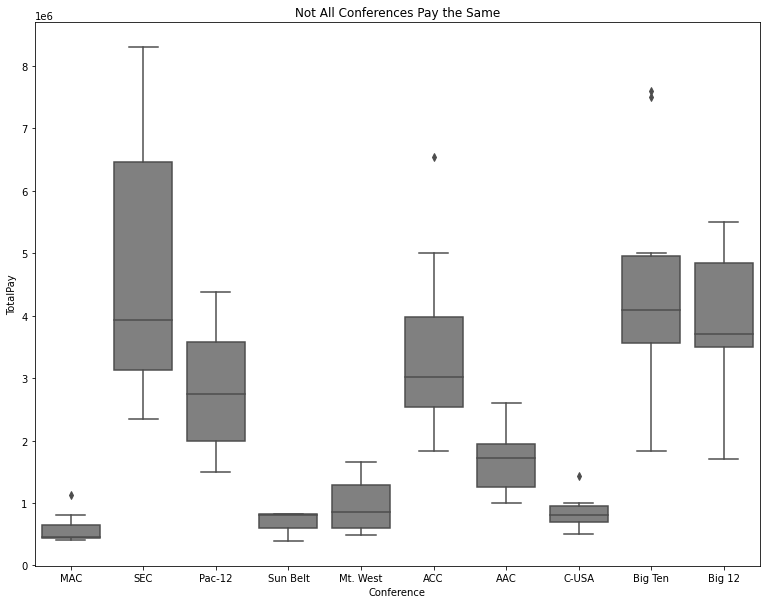

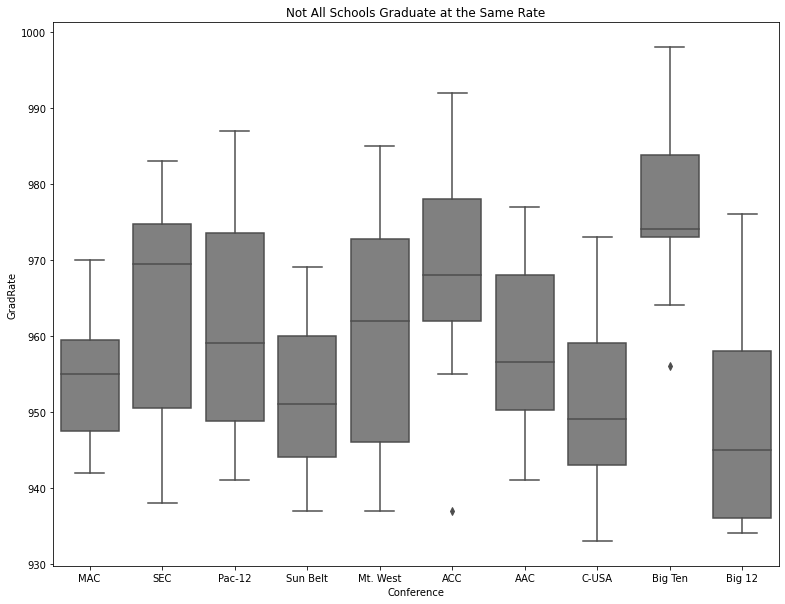

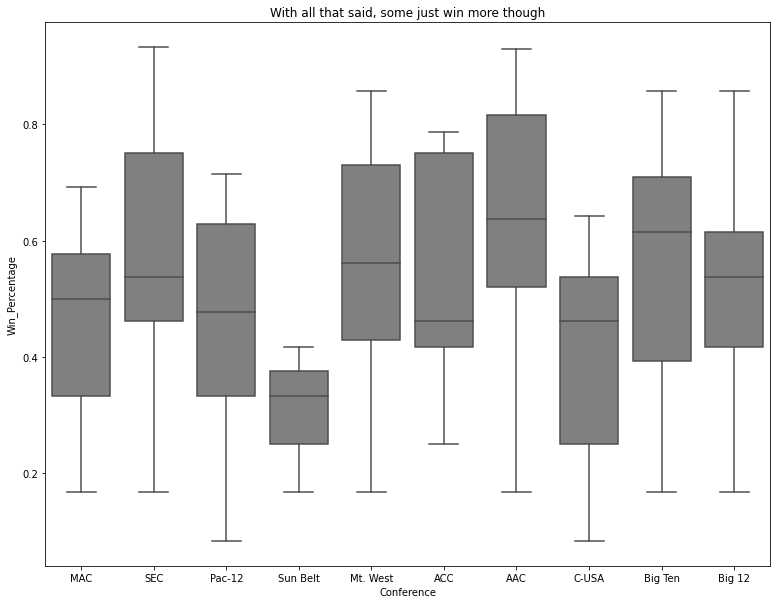

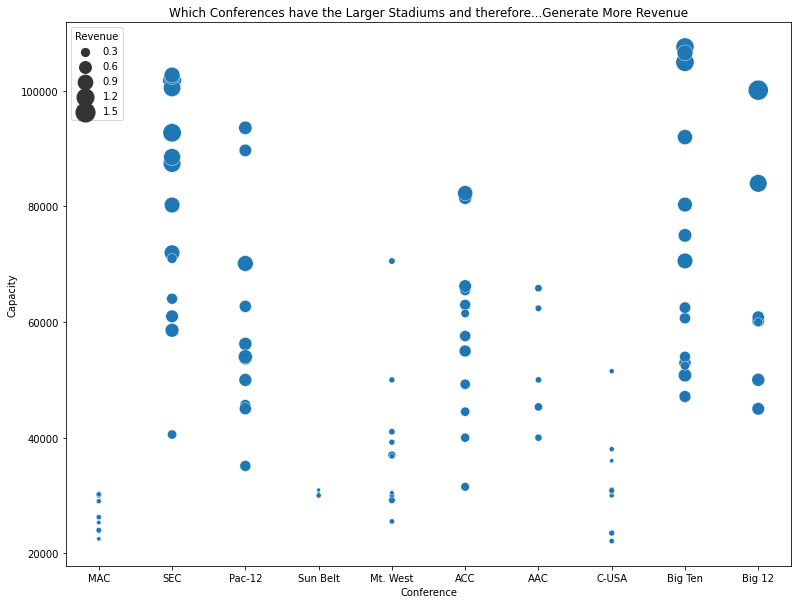

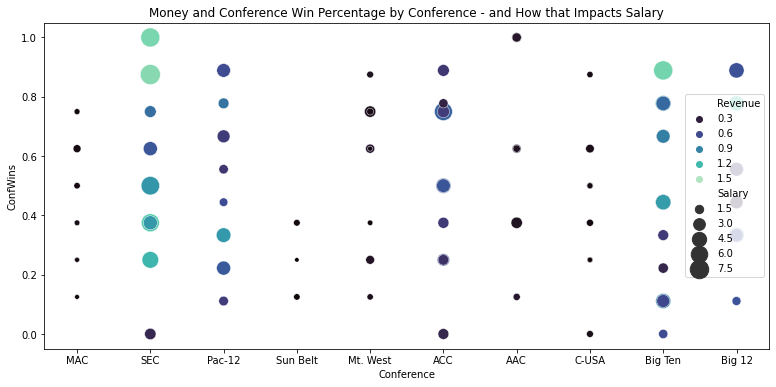

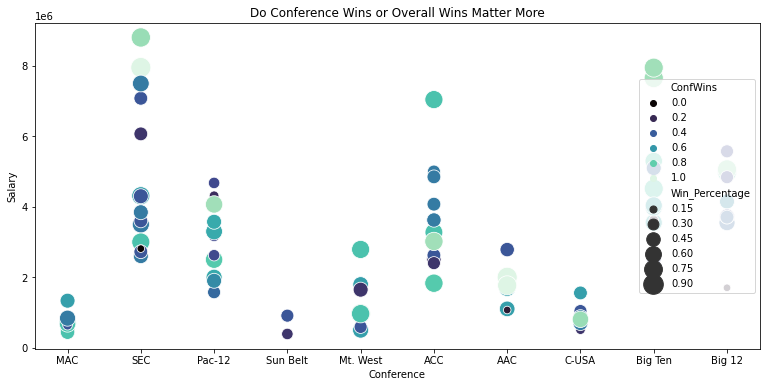

In [78]:
# Time for some visuals
#boxplot conference and pay
plt.figure(figsize=(13,10))
sns.boxplot(x='Conference', y='TotalPay', data=mergefeastfinal, color = "gray");
# Give title
title = 'Not All Conferences Pay the Same'
plt.title(title)
# Save graph
plt.savefig(title, dpi=400)
plt.show()

#boxplot conference and graduation rate
plt.figure(figsize=(13,10))
sns.boxplot(x='Conference', y='GradRate', data=mergefeastfinal, color = "gray");
# Give title
title = 'Not All Schools Graduate at the Same Rate'
plt.title(title)
# Save graph
plt.savefig(title, dpi=400)
plt.show()

#boxplot conference and graduation rate
plt.figure(figsize=(13,10))
sns.boxplot(x='Conference', y='Win_Percentage', data=mergefeastfinal, color = "gray");
# Give title
title = 'With all that said, some just win more though'
plt.title(title)
# Save graph
plt.savefig(title, dpi=400)
plt.show()


#Scatterplot of capacity and revenue by Conference
plt.figure(figsize=(13,10))
sns.scatterplot(x='Conference', y='Capacity', data=mergefeastfinal, size = 'Revenue', sizes=(10, 400), palette='mako');
# Give title
title = 'Which Conferences have the Larger Stadiums and therefore...Generate More Revenue'
plt.title(title)
# Save graph
plt.show()

# Scatterplot money and conference wins
plt.figure(figsize=(13,6))
sns.scatterplot(x=mergefeastfinal['Conference'], y=mergefeastfinal['ConfWins'],
               size=mergefeastfinal['Salary'], hue=mergefeastfinal['Revenue'],
               sizes=(20,400), palette='mako')
# Give title
title = 'Money and Conference Win Percentage by Conference - and How that Impacts Salary'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.legend(loc='center right', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Scatterplot money and win percentage
plt.figure(figsize=(13,6))
sns.scatterplot(x=mergefeastfinal['Conference'], y=mergefeastfinal['Salary'],
               size=mergefeastfinal['Win_Percentage'], hue=mergefeastfinal['ConfWins'],
               sizes=(20,400), palette='mako')
# Give title
title = 'Do Conference Wins or Overall Wins Matter More'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.legend(loc='center right', bbox_to_anchor=(1.0, 0.5))
plt.show()
#looked up how to make the output larger and change the sizes of the markers here: https://seaborn.pydata.org/generated/seaborn.scatterplot.html
#and how to move the legend off the center of the plot on stack overflow

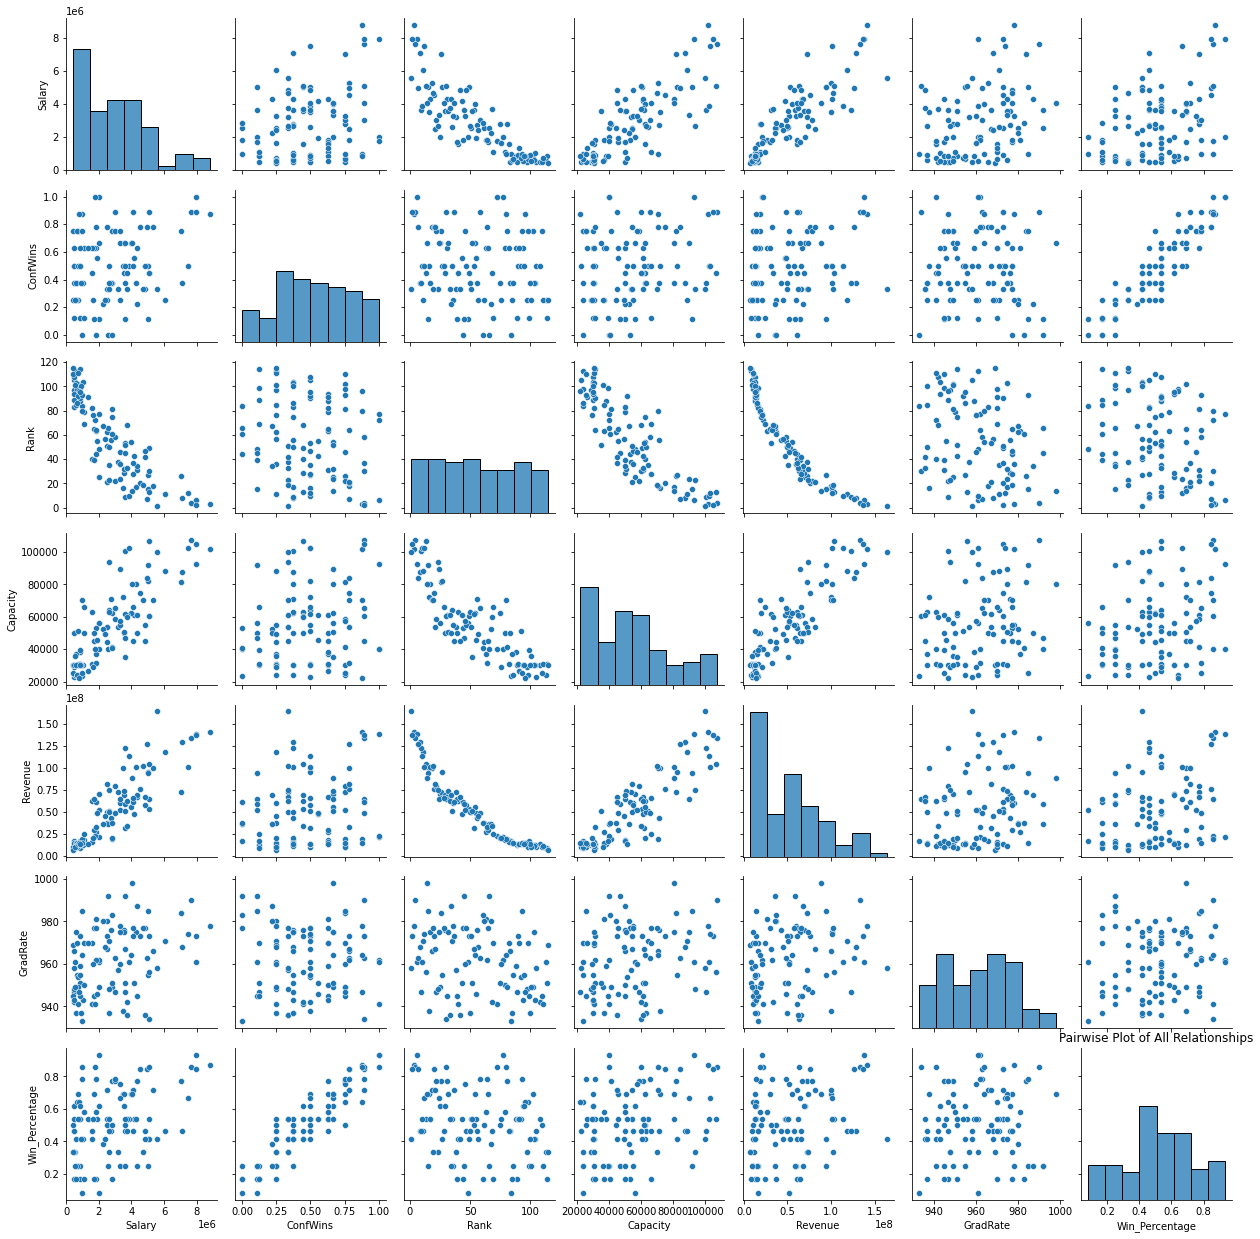

In [77]:
#pairwise plot of all key variable relationships
selectedcolls=mergefeastfinal[['Salary','ConfWins', 'Rank', 'Capacity','Revenue','GradRate','Win_Percentage']]
sns.pairplot(selectedcolls, palette='Greys')
# Give title
title = 'Pairwise Plot of All Relationships'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.show()

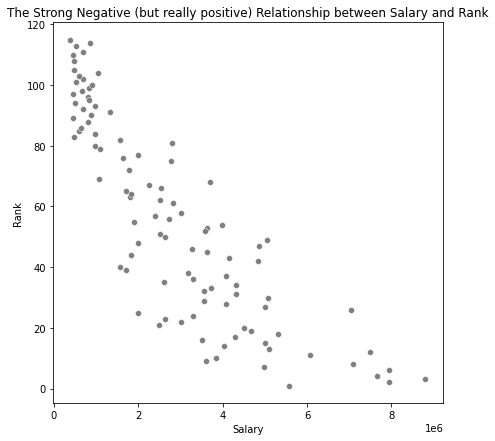

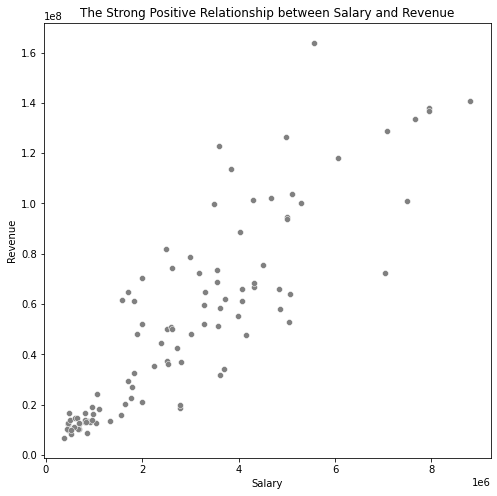

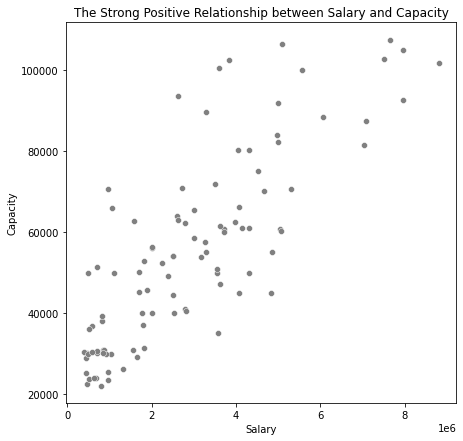

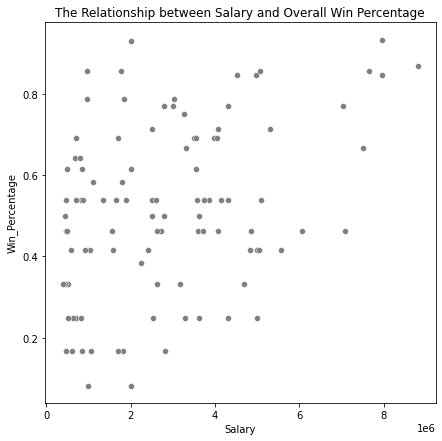

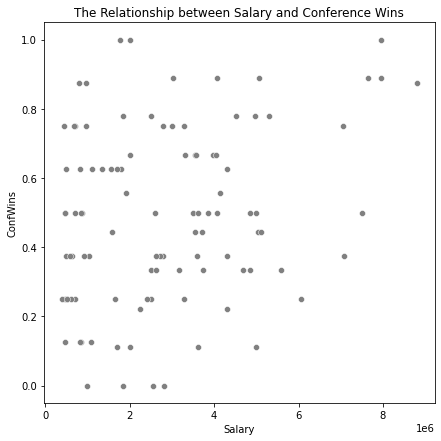

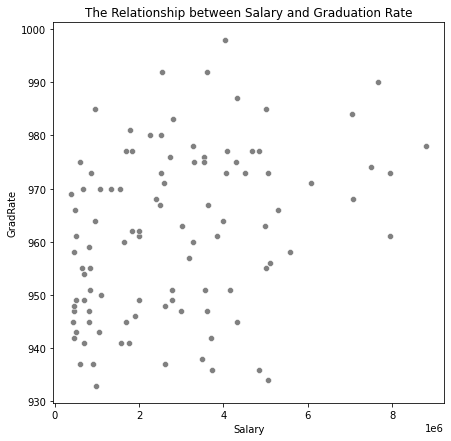

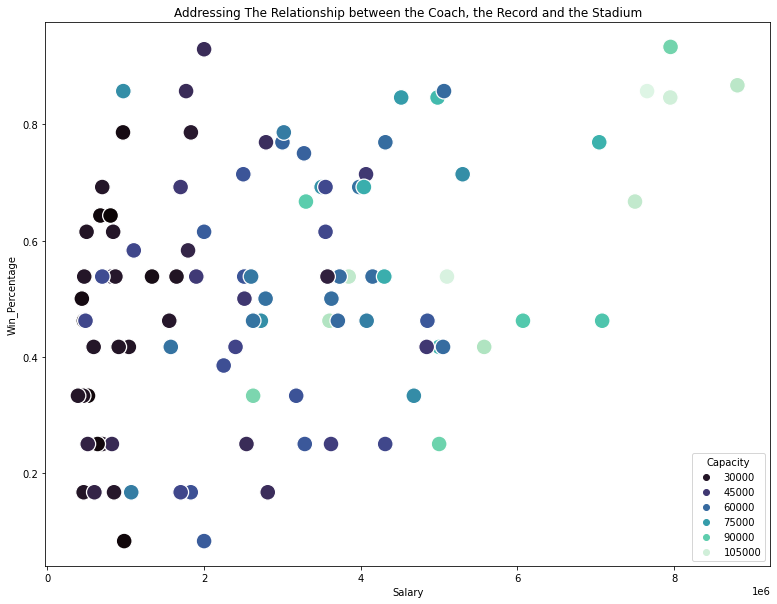

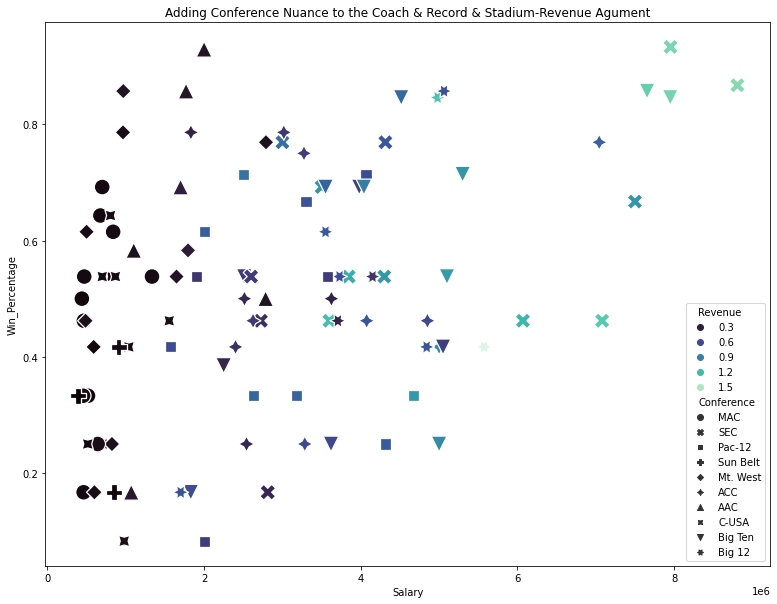

In [76]:
# Taking that pairwise plot and isolating some specific relationsips to highlight
plt.figure(figsize=(7,7))
sns.scatterplot(x='Salary', y='Rank', data=mergefeastfinal, color = "gray")
# Give title
title = 'The Strong Negative (but really positive) Relationship between Salary and Rank'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.show()

plt.figure(figsize=(8,8))
sns.scatterplot(x='Salary', y='Revenue', data=mergefeastfinal, color = "gray")
# Give title
title = 'The Strong Positive Relationship between Salary and Revenue'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.show()

plt.figure(figsize=(7,7))
sns.scatterplot(x='Salary', y='Capacity', data=mergefeastfinal, color = "gray")
# Give title
title = 'The Strong Positive Relationship between Salary and Capacity'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.show()

plt.figure(figsize=(7,7))
sns.scatterplot(x='Salary', y='Win_Percentage', data=mergefeastfinal, color = "gray")
# Give title
title = 'The Relationship between Salary and Overall Win Percentage'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.show()

plt.figure(figsize=(7,7))
sns.scatterplot(x='Salary', y='ConfWins', data=mergefeastfinal, color = "gray")
# Give title
title = 'The Relationship between Salary and Conference Wins'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.show()

plt.figure(figsize=(7,7))
sns.scatterplot(x='Salary', y='GradRate', data=mergefeastfinal, color = "gray")
# Give title
title = 'The Relationship between Salary and Graduation Rate'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.show()

plt.figure(figsize=(13,10))
sns.scatterplot(x="Salary", y="Win_Percentage", hue="Capacity", data=mergefeastfinal, palette='mako',  s=250)
# Give title
title = 'Addressing The Relationship between the Coach, the Record and the Stadium'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.show()

plt.figure(figsize=(13,10))
sns.scatterplot(x=mergefeastfinal['Salary'], y=mergefeastfinal['Win_Percentage'],
            hue=mergefeastfinal['Revenue'], style=mergefeastfinal['Conference'],
            sizes=(200), palette='mako',  s=250)
# Give title
title = 'Adding Conference Nuance to the Coach & Record & Stadium-Revenue Agument'
plt.title(title)
# Save graph
plt.savefig(title, dpi=200)
plt.show()

In [39]:
#I think we may need to order some data

ordered_conference={ 
    'ACC' : '1ACC', 
    'SEC' : '2SEC.',
    'Big 12' : '3Big 12', 
    'Big Ten' : '4Big Ten', 
    'C-USA' : '5C-USA',
    'Ind.' : '6Ind.',
    'MAC' : '7MAC',
    'Mt. West': '8Mt. West', 
    'Pac-12' : '9Pac-12',
    'Sun Belt' : '11Sun Belt',
    'AAC' : '12AAC'}

mergefeastfinal['ConfOrder'] = mergefeastfinal['Conference'].map(ordered_conference)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
# employ training-and-test regimen for model validation
np.random.seed(1234)
mergefeastfinal['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(mergefeastfinal))

data_train = mergefeastfinal[mergefeastfinal['runiform'] >= 0.33]
data_test = mergefeastfinal[mergefeastfinal['runiform'] < 0.33]

In [ ]:
# check training data frame
print('\ndata_train data frame (rows, columns): ',data_train.shape)
print(data_train.head())
# check test data frame
print('\ndata_test data frame (rows, columns): ',data_test.shape)
print(data_test.head())

In [ ]:
# Just to remind me of my column names
mergefeastfinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            101 non-null    int64  
 1   Coach                 101 non-null    object 
 2   School                101 non-null    object 
 3   Conference            101 non-null    object 
 4   TotalPay              101 non-null    float64
 5   BonusPaid             101 non-null    float64
 6   ConfWins              101 non-null    float64
 7   Win_Percentage        101 non-null    float64
 8   Rank                  101 non-null    float64
 9   Capacity              101 non-null    float64
 10  Revenue               101 non-null    float64
 11  GradRate              101 non-null    float64
 12  NUM_OF_ATHLETES_2014  101 non-null    float64
 13  RAW_OR_CI             101 non-null    float64
 14  Salary                101 non-null    float64
 15  ConfOrder             1

In [44]:
# specify a simple model with ALL of the possible influencing variables identified
all_model = str('Salary ~ Rank + Revenue + Capacity + ConfWins + GradRate + Win_Percentage')

# fit the model to the training set

train_model_fitall = smf.ols(all_model, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitall.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitall.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitall.predict(data_test)


                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     54.25
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           8.11e-24
Time:                        13:46:56   Log-Likelihood:                -1117.3
No. Observations:                  74   AIC:                             2249.
Df Residuals:                      67   BIC:                             2265.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.055e+07   6.59e+06     -1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [45]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample - especially important since our dataset is rather small
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect on salary due to grad rate 
my_model_fitall = smf.ols(all_model, data = mergefeastfinal).fit()
print(my_model_fitall.summary())

print('\nEstimated Effect of Grad Rate on Salary: ',\
    round(my_model_fitall.params['GradRate'],0))


Proportion of Test Set Variance Accounted for:  0.742
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     63.47
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           6.66e-31
Time:                        13:46:59   Log-Likelihood:                -1527.8
No. Observations:                 101   AIC:                             3070.
Df Residuals:                      94   BIC:                             3088.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [47]:
# specify a simple model with variables identified
# since revenue and capacity are linked and rank/conf wins/win_percentage are as well, now it's time to play with some models and find the optimal configuration
select_model1 = str('Salary ~ Rank + Revenue + ConfWins + GradRate')

# fit the model to the training set

train_model_fitselect1 = smf.ols(select_model1, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitselect1.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitselect1.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitselect1.predict(data_test)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     77.23
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           9.68e-25
Time:                        13:49:51   Log-Likelihood:                -1119.8
No. Observations:                  74   AIC:                             2250.
Df Residuals:                      69   BIC:                             2261.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.119e+07   6.69e+06     -1.672      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect of conference on salary
my_model_fitselect1 = smf.ols(select_model1, data = mergefeastfinal).fit()
print(my_model_fitselect1.summary())


Proportion of Test Set Variance Accounted for:  0.757
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     93.22
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           3.39e-32
Time:                        13:49:55   Log-Likelihood:                -1529.5
No. Observations:                 101   AIC:                             3069.
Df Residuals:                      96   BIC:                             3082.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [49]:
# Still playing with the variables to find the optimal configuration and continueing with revenue in lieu of capacity
# But this one looked at overall wins versus select model 1 which looked at conference wins
select_model2 = str('Salary ~ Rank + Revenue + Win_Percentage + GradRate')

# fit the model to the training set

train_model_fitselect2 = smf.ols(select_model2, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitselect2.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitselect2.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitselect2.predict(data_test)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     79.56
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           4.20e-25
Time:                        13:50:20   Log-Likelihood:                -1118.9
No. Observations:                  74   AIC:                             2248.
Df Residuals:                      69   BIC:                             2259.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.054e+07   6.61e+06     -1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect of conference on salary
my_model_fitselect2 = smf.ols(select_model2, data = mergefeastfinal).fit()
print(my_model_fitselect2.summary())

print('\nEstimated Effect of Grad Rate on Salary: ',\
    round(my_model_fitall.params['GradRate'],0))


Proportion of Test Set Variance Accounted for:  0.799
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     94.48
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           2.04e-32
Time:                        17:34:31   Log-Likelihood:                -1529.0
No. Observations:                 101   AIC:                             3068.
Df Residuals:                      96   BIC:                             3081.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [51]:
# Still playing with the variables to find the optimal configuration and continueing with revenue in lieu of capacity
# This one reverts back to conference wins and strips out Rank as one would hope that is linked to win percentage and Conference Wins
select_model3 = str('Salary ~ Revenue + ConfWins + GradRate')

# fit the model to the training set

train_model_fitselect3 = smf.ols(select_model3, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitselect3.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitselect3.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitselect3.predict(data_test)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     101.2
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           2.14e-25
Time:                        13:50:59   Log-Likelihood:                -1120.7
No. Observations:                  74   AIC:                             2249.
Df Residuals:                      70   BIC:                             2259.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.328e+07   6.55e+06     -2.029      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect of conference on salary
my_model_fitselect3 = smf.ols(select_model3, data = mergefeastfinal).fit()
print(my_model_fitselect3.summary())


Proportion of Test Set Variance Accounted for:  0.749
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     121.9
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           8.77e-33
Time:                        13:51:04   Log-Likelihood:                -1530.7
No. Observations:                 101   AIC:                             3069.
Df Residuals:                      97   BIC:                             3080.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [53]:
# Still playing with the variables to find the optimal configuration and continueing with revenue in lieu of capacity
# This one flips model 3 and looks at win percentage with grad rate versus conf wins
select_model4 = str('Salary ~ Revenue + Win_Percentage + GradRate')

# fit the model to the training set

train_model_fitselect4 = smf.ols(select_model4, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitselect4.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitselect4.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitselect4.predict(data_test)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     104.7
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           8.02e-26
Time:                        13:51:13   Log-Likelihood:                -1119.7
No. Observations:                  74   AIC:                             2247.
Df Residuals:                      70   BIC:                             2257.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.243e+07   6.45e+06     -1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect of conference on salary
my_model_fitselect4 = smf.ols(select_model4, data = mergefeastfinal).fit()
print(my_model_fitselect4.summary())


Proportion of Test Set Variance Accounted for:  0.747
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     124.1
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           4.42e-33
Time:                        13:51:18   Log-Likelihood:                -1530.0
No. Observations:                 101   AIC:                             3068.
Df Residuals:                      97   BIC:                             3079.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [55]:
# Still playing with the variables to find the optimal configuration and continueing with revenue in lieu of capacity
# Even though there must be multicollinearity with win percentage and conf wins, thought it would be worth a quick test
select_model5 = str('Salary ~ Revenue + Win_Percentage + ConfWins + GradRate')

# fit the model to the training set

train_model_fitselect5 = smf.ols(select_model5, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitselect5.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitselect5.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitselect5.predict(data_test)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     77.50
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           8.77e-25
Time:                        13:51:23   Log-Likelihood:                -1119.7
No. Observations:                  74   AIC:                             2249.
Df Residuals:                      69   BIC:                             2261.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.228e+07   6.54e+06     -1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect of conference on salary
my_model_fitselect5 = smf.ols(select_model5, data = mergefeastfinal).fit()
print(my_model_fitselect5.summary())


Proportion of Test Set Variance Accounted for:  0.747
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     92.11
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           5.36e-32
Time:                        13:51:27   Log-Likelihood:                -1530.0
No. Observations:                 101   AIC:                             3070.
Df Residuals:                      96   BIC:                             3083.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [57]:
# Still playing with the variables to find the optimal configuration and continueing with revenue in lieu of capacity
# This one strips out graduation rate to isolate that impact
select_model6 = str('Salary ~ Revenue + Rank + Win_Percentage')

# fit the model to the training set

train_model_fitselect6 = smf.ols(select_model6, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitselect6.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitselect6.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitselect6.predict(data_test)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     102.0
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           1.70e-25
Time:                        13:51:30   Log-Likelihood:                -1120.5
No. Observations:                  74   AIC:                             2249.
Df Residuals:                      70   BIC:                             2258.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       9.272e+05    9.7e+05      0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect of conference on salary
my_model_fitselect6 = smf.ols(select_model6, data = mergefeastfinal).fit()
print(my_model_fitselect6.summary())


Proportion of Test Set Variance Accounted for:  0.732
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     118.6
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           2.52e-32
Time:                        13:51:32   Log-Likelihood:                -1531.8
No. Observations:                 101   AIC:                             3072.
Df Residuals:                      97   BIC:                             3082.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [59]:
# Thus far, the optial configurations are the model that included all the variables and model 2
# Therefore this one selects model 2 and swaps revenue and capacity to address which of these two related variables has the significant impact on salary
select_model7 = str('Salary ~ Rank + Capacity + Win_Percentage + GradRate')

# fit the model to the training set

train_model_fitselect7 = smf.ols(select_model7, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitselect7.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitselect7.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitselect7.predict(data_test)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     67.38
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           4.21e-23
Time:                        13:51:35   Log-Likelihood:                -1123.9
No. Observations:                  74   AIC:                             2258.
Df Residuals:                      69   BIC:                             2269.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -7.557e+06   7.01e+06     -1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect of conference on salary
my_model_fitselect7 = smf.ols(select_model7, data = mergefeastfinal).fit()
print(my_model_fitselect7.summary())

# Ha!  It's not capacity of the statium but revenue, I suppose that is due to some of the legacy schools that had their heyday and built massive stadiums


Proportion of Test Set Variance Accounted for:  0.713
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     80.73
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           7.35e-30
Time:                        13:51:40   Log-Likelihood:                -1535.2
No. Observations:                 101   AIC:                             3080.
Df Residuals:                      96   BIC:                             3094.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [63]:
# Now that we know (or think we know) what model is the best (Select_model2), time to try all the variables minus the capacity
select_model8 = str('Salary ~ Rank + Revenue + Win_Percentage + ConfWins + GradRate')

# fit the model to the training set

train_model_fitselect8 = smf.ols(select_model8, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitselect8.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitselect8.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitselect8.predict(data_test)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     62.74
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           3.98e-24
Time:                        14:14:09   Log-Likelihood:                -1118.9
No. Observations:                  74   AIC:                             2250.
Df Residuals:                      68   BIC:                             2264.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.046e+07   6.68e+06     -1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [64]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect of conference on salary
my_model_fitselect8 = smf.ols(select_model8, data = mergefeastfinal).fit()
print(my_model_fitselect8.summary())


Proportion of Test Set Variance Accounted for:  0.754
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     74.80
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           2.12e-31
Time:                        14:14:15   Log-Likelihood:                -1529.0
No. Observations:                 101   AIC:                             3070.
Df Residuals:                      95   BIC:                             3086.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

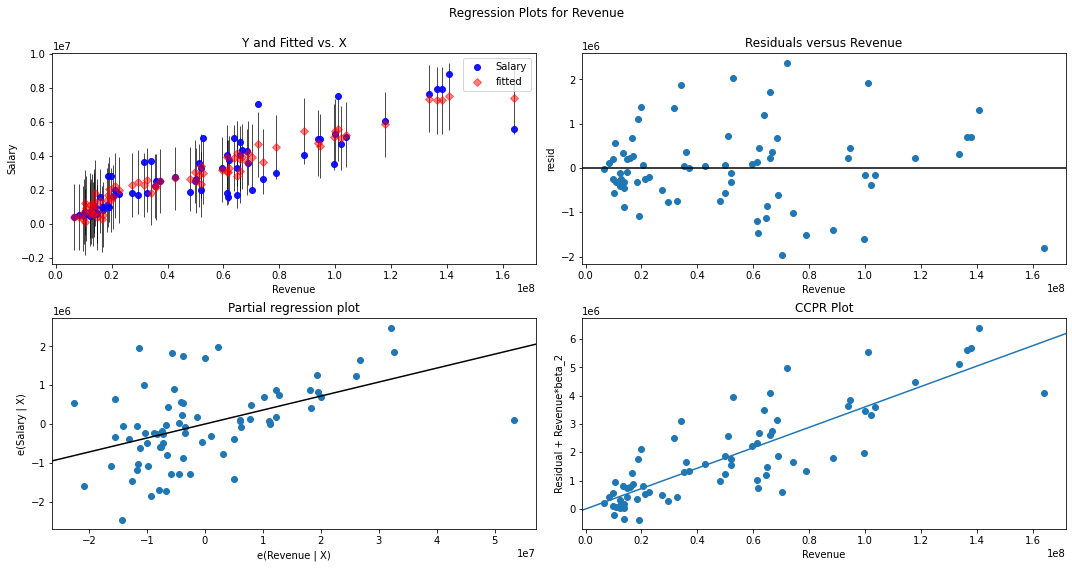

In [ ]:
# Revenue seems to be the most consistent significant variable impacting salary

fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(train_model_fitselect2, "Revenue", fig=fig)

In [65]:
# now that we know (or think we know) which model is best (select_model2), time to add conference in and see how conference impacts salary

conf_model = str('Salary ~ ConfOrder + Rank + Revenue + Win_Percentage + GradRate')

# fit the model to the training set
train_model_fitconf = smf.ols(conf_model, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fitconf.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fitconf.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fitconf.predict(data_test)

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     24.34
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           3.82e-19
Time:                        14:17:47   Log-Likelihood:                -1114.8
No. Observations:                  74   AIC:                             2258.
Df Residuals:                      60   BIC:                             2290.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [66]:
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(data_test['Salary'].corr(data_test['predict_salary']),2),3))

# use the full data set to obtain an estimate of the increase in
# Effect of conference on salary
my_model_fitconf = smf.ols(conf_model, data = mergefeastfinal).fit()
print(my_model_fitconf.summary())

# and let's try to isolate the specific value of some conferences
print('\nEstimated Value of the AAC (Formerlly Known as the Big East): ',\
    round(my_model_fitconf.params['ConfOrder[T.12AAC]'],0))

print('\nEstimated Value of the Big Ten: ',\
    round(my_model_fitconf.params['ConfOrder[T.4Big Ten]'],0))

print('\nEstimated Value of the ACC: ',\
    round(my_model_fitconf.params['ConfOrder[T.1ACC]'],0))


Proportion of Test Set Variance Accounted for:  0.799
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     30.97
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           4.25e-27
Time:                        14:17:52   Log-Likelihood:                -1522.4
No. Observations:                 101   AIC:                             3073.
Df Residuals:                      87   BIC:                             3109.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


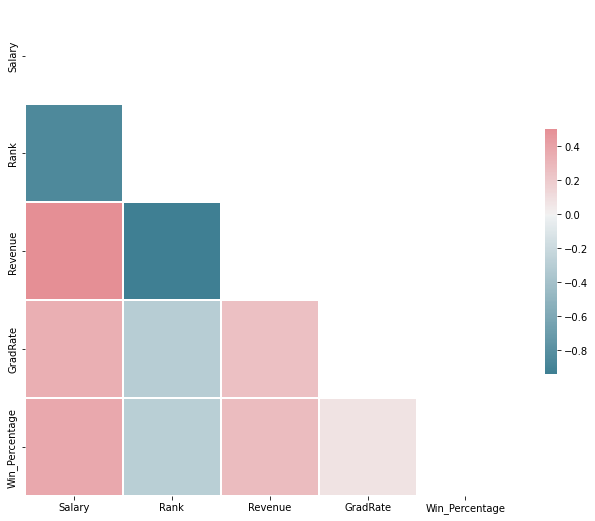

In [89]:
selectedmodelcolls=mergefeastfinal[['Salary','Rank', 'Revenue','GradRate','Win_Percentage']]
corr = selectedmodelcolls.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .5})

In [68]:
#time to do some prediction - starting with the Syracuse base salary
mergefeastfinal['predict_salary']=train_model_fitselect2.predict(mergefeastfinal)
orangefootball=mergefeastfinal.loc[mergefeastfinal['School']=='Syracuse']
orangepredict=round(orangefootball.predict_salary,0)
orangepredict


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


102    2564931.0
Name: predict_salary, dtype: float64

In [69]:
#and then when we take conference into the equation
mergefeastfinal['predict_salary']=train_model_fitconf.predict(mergefeastfinal)
orangefootball=mergefeastfinal.loc[mergefeastfinal['School']=='Syracuse']
orangepredict=round(orangefootball.predict_salary,0)
orangepredict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


102    3050714.0
Name: predict_salary, dtype: float64